In [1]:
# use geo_env_2022
import os
import numpy as np
import pandas as pd # original 1.2.3
import geopandas as gpd
from shapely.geometry import Point
import pickle
import urllib.request

import matplotlib.pyplot as plt

In [2]:
def get_exposure():


    data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

    pkl_file = open(f'{data_dir}df_ucdp_prio.pkl', 'rb')

    combined_df = pickle.load(pkl_file)
    pkl_file.close()

    return combined_df

In [3]:
combined_df = get_exposure()

In [4]:
for y in sorted(combined_df['year'].unique()):
    array = combined_df[combined_df['year'] == y]['month_id'].unique()
    print(f'{y}: {array}, lenght = {array.shape[0]}')

1989: [109 110 111 112 113 114 115 116 117 118 119 120], lenght = 12
1990: [121 122 123 124 125 126 127 128 129 130 131 132], lenght = 12
1991: [133 134 135 136 137 138 139 140 141 142 143 144], lenght = 12
1992: [145 146 147 148 149 150 151 152 153 154 155 156], lenght = 12
1993: [157 158 159 160 161 162 163 164 165 166 167 168], lenght = 12
1994: [169 170 171 172 173 174 175 176 177 178 179 180], lenght = 12
1995: [181 182 183 184 185 186 187 188 189 190 191 192], lenght = 12
1996: [193 194 195 196 197 198 199 200 201 202 203 204], lenght = 12
1997: [205 206 207 208 209 210 211 212 213 214 215 216], lenght = 12
1998: [217 218 219 220 221 222 223 224 225 226 227 228], lenght = 12
1999: [229 230 231 232 233 234 235 236 237 238 239 240], lenght = 12
2000: [241 242 243 244 245 246 247 248 249 250 251 252], lenght = 12
2001: [253 254 255 256 257 258 259 260 261 262 263 264], lenght = 12
2002: [265 266 267 268 269 270 271 272 273 274 275 276], lenght = 12
2003: [277 278 279 280 281 282 283

In [5]:
combined_df

,gid,xcoord,ycoord,col,row,geometry,year,gwno,month,year_months_start,month_id,best,low,high,log_best,log_low,log_high
0,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,01,2003-01,277,0.0,0.0,0.0,0.0,0.0,0.0
1,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,02,2003-02,278,0.0,0.0,0.0,0.0,0.0,0.0
2,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,03,2003-03,279,0.0,0.0,0.0,0.0,0.0,0.0
3,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,04,2003-04,280,0.0,0.0,0.0,0.0,0.0,0.0
4,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,05,2003-05,281,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24112858,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,08,2019-08,476,0.0,0.0,0.0,0.0,0.0,0.0
24112859,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,09,2019-09,477,0.0,0.0,0.0,0.0,0.0,0.0
24112860,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,10,2019-10,478,0.0,0.0,0.0,0.0,0.0,0.0
24112861,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,11,2019-11,479,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(combined_df.crs)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


409: 2014-01


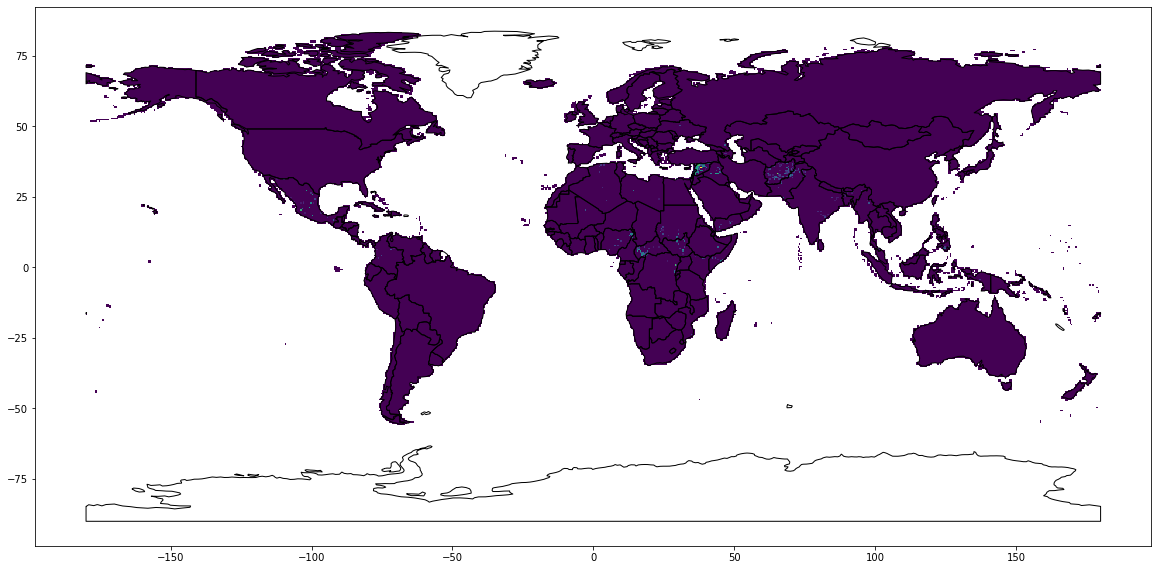

410: 2014-02


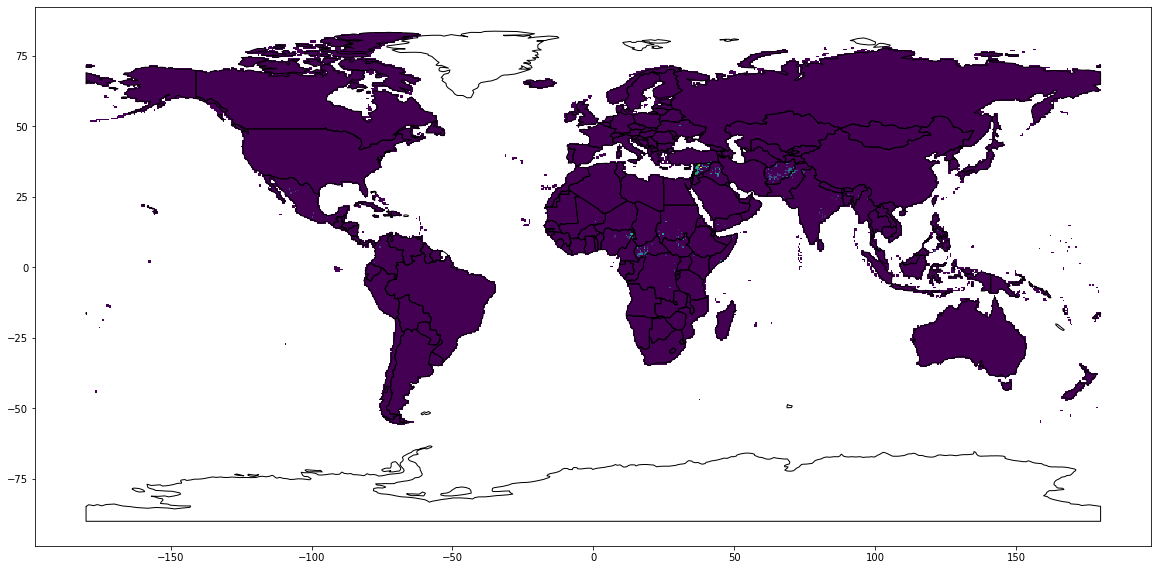

411: 2014-03


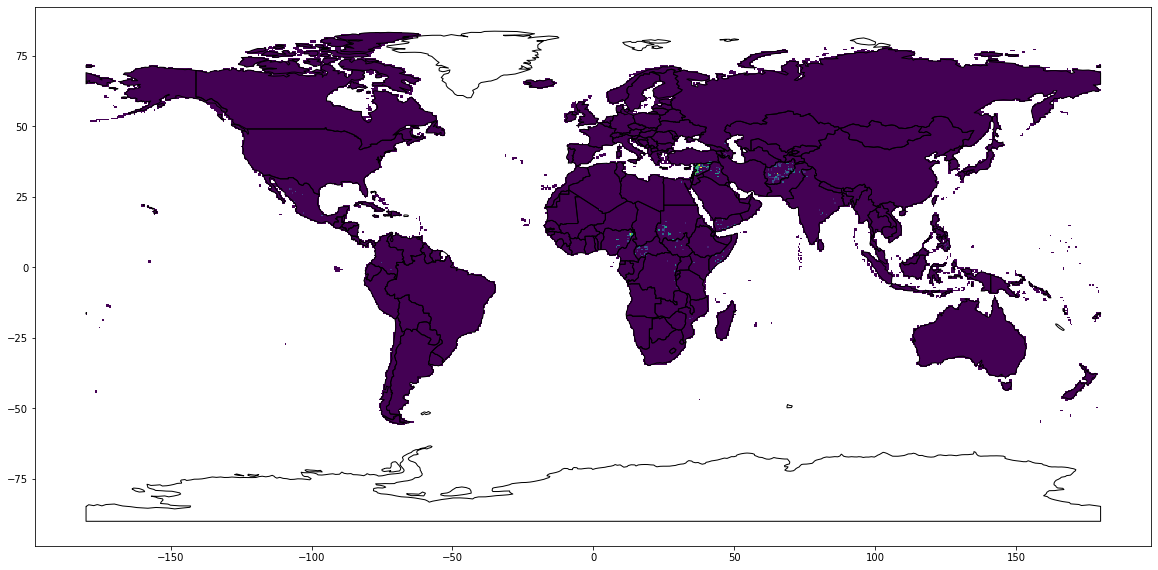

412: 2014-04


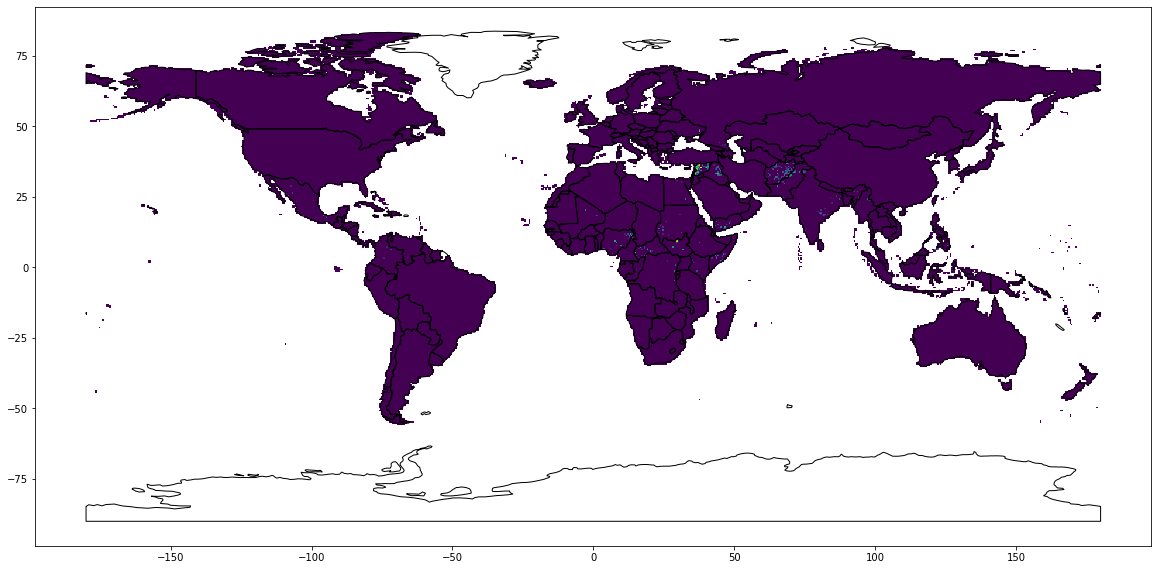

413: 2014-05


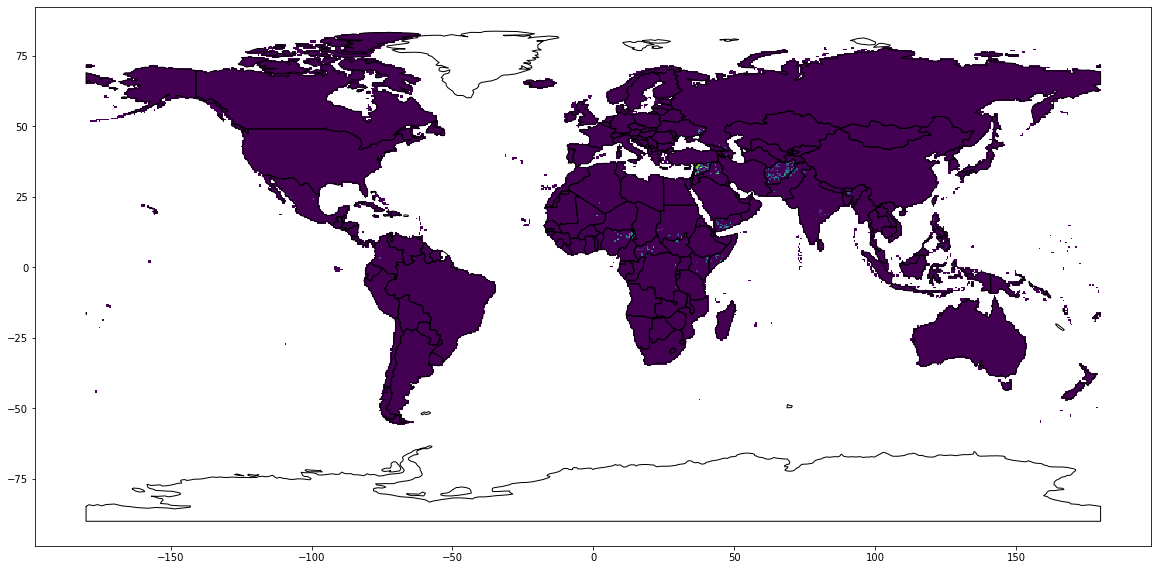

In [7]:
for i in sorted(combined_df['month_id'].unique())[300:305]:

    print(f"{i}: {combined_df[combined_df['month_id'] == i]['year_months_start'].unique().item()}")
    fig, ax = plt.subplots(figsize = (20,20))
    combined_df[combined_df['month_id'] == i].plot(ax=ax, column = 'log_best')
    world.plot(facecolor='none', edgecolor='black', ax=ax)
    plt.show()

Seem legit

In [8]:
def get_bodies_data(combined_df):    
    
    data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

    with open(f'{data_dir}df_od_coordinates_full.pkl', 'rb') as file:
        bodies_df = pickle.load(file)

    # correction for wierd long string...
    bodies_df.loc[bodies_df['year'].str.len() == bodies_df['year'].str.len().max(), 'year'] = bodies_df.loc[bodies_df['year'].str.len() == bodies_df['year'].str.len().max(), 'date'].astype(str).str.slice(start = 0, stop = 4).item()

    # correction droping 111 nans ido not know where entered..
    bodies_df.drop(index = bodies_df.loc[bodies_df['year'].str.len() != 4].index, inplace = True)

    geometry = [Point(xy) for xy in zip(bodies_df['longitude_full'], bodies_df['latitude_full'])]
    bodies_gdf = gpd.GeoDataFrame(bodies_df, crs = combined_df.crs, geometry = geometry)

    return(bodies_gdf)

In [9]:
def get_month_id_bodies(bodies_gdf):

    # works!!
    years = np.arange(1989,2020,1) # just as big as combine for now
    #months = [np.arange(1,13,1)] * years.shape[0]
    months = [[str(i).zfill(2) for i in np.arange(1,13,1)]] * years.shape[0]

    month_id_df = pd.DataFrame({'year' : years, 'month' : months}).explode('month')
    month_id_df['month_id'] = np.arange(109, month_id_df.shape[0] + 109, 1)

    month_id_df['year_month'] = month_id_df['year'].astype(str) + '-' + month_id_df['month']
    bodies_gdf['year_month']= bodies_gdf['date'].astype(str).str.slice(start = 0, stop = 7)
    bodies_gdf_month_id = bodies_gdf.merge(month_id_df[['month_id','year_month']], how='left', on= 'year_month')

    return(bodies_gdf_month_id)

In [10]:
bodies_gdf = get_bodies_data(combined_df)
bodies_gdf_month_id = get_month_id_bodies(bodies_gdf)

# YOU NEED TO FIND OUT WHERE THIS FUCKED UP!!!

In [11]:
bodies_gdf_month_id['new_year'] = bodies_gdf_month_id['date'].astype(str).str.slice(start = 0, stop = 4)

In [12]:
for y in sorted(combined_df['year'].unique()):
    array = combined_df[combined_df['year'] == y]['month_id'].unique()
    print(f'{y}: {array}, lenght = {array.shape[0]}')

for y in sorted(bodies_gdf_month_id['new_year'].unique()):
    array = bodies_gdf_month_id[bodies_gdf_month_id['new_year'] == y]['month_id'].unique()
    print(f'{y}: {array}, lenght = {array.shape[0]}')

1989: [109 110 111 112 113 114 115 116 117 118 119 120], lenght = 12
1990: [121 122 123 124 125 126 127 128 129 130 131 132], lenght = 12
1991: [133 134 135 136 137 138 139 140 141 142 143 144], lenght = 12
1992: [145 146 147 148 149 150 151 152 153 154 155 156], lenght = 12
1993: [157 158 159 160 161 162 163 164 165 166 167 168], lenght = 12
1994: [169 170 171 172 173 174 175 176 177 178 179 180], lenght = 12
1995: [181 182 183 184 185 186 187 188 189 190 191 192], lenght = 12
1996: [193 194 195 196 197 198 199 200 201 202 203 204], lenght = 12
1997: [205 206 207 208 209 210 211 212 213 214 215 216], lenght = 12
1998: [217 218 219 220 221 222 223 224 225 226 227 228], lenght = 12
1999: [229 230 231 232 233 234 235 236 237 238 239 240], lenght = 12
2000: [241 242 243 244 245 246 247 248 249 250 251 252], lenght = 12
2001: [253 254 255 256 257 258 259 260 261 262 263 264], lenght = 12
2002: [265 266 267 268 269 270 271 272 273 274 275 276], lenght = 12
2003: [277 278 279 280 281 282 283

# sjoin

In [13]:
def get_cshapes():
    location = '/home/simon/Documents/Bodies/data/PRIO' 
    path_cshapes = location + "/CShapes-2.0.csv"
    
    if os.path.isfile(path_cshapes) == True:
        print('file already downloaded')
        cshapes = pd.read_csv(path_cshapes)


    else: 
        print('Beginning file download CShapes...')

        url_cshapes = 'https://icr.ethz.ch/data/cshapes/CShapes-2.0.csv'
    
        urllib.request.urlretrieve(url_cshapes, path_cshapes)
        cshapes = pd.read_csv(path_cshapes)

    return cshapes


In [14]:
cshapes = get_cshapes()

file already downloaded


In [15]:
cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()
gid_geom_df = combined_df.loc[(combined_df['gwno'].isin(gwno_to_keep)), ['gid', 'geometry']].drop_duplicates().copy()

289: 2004-01


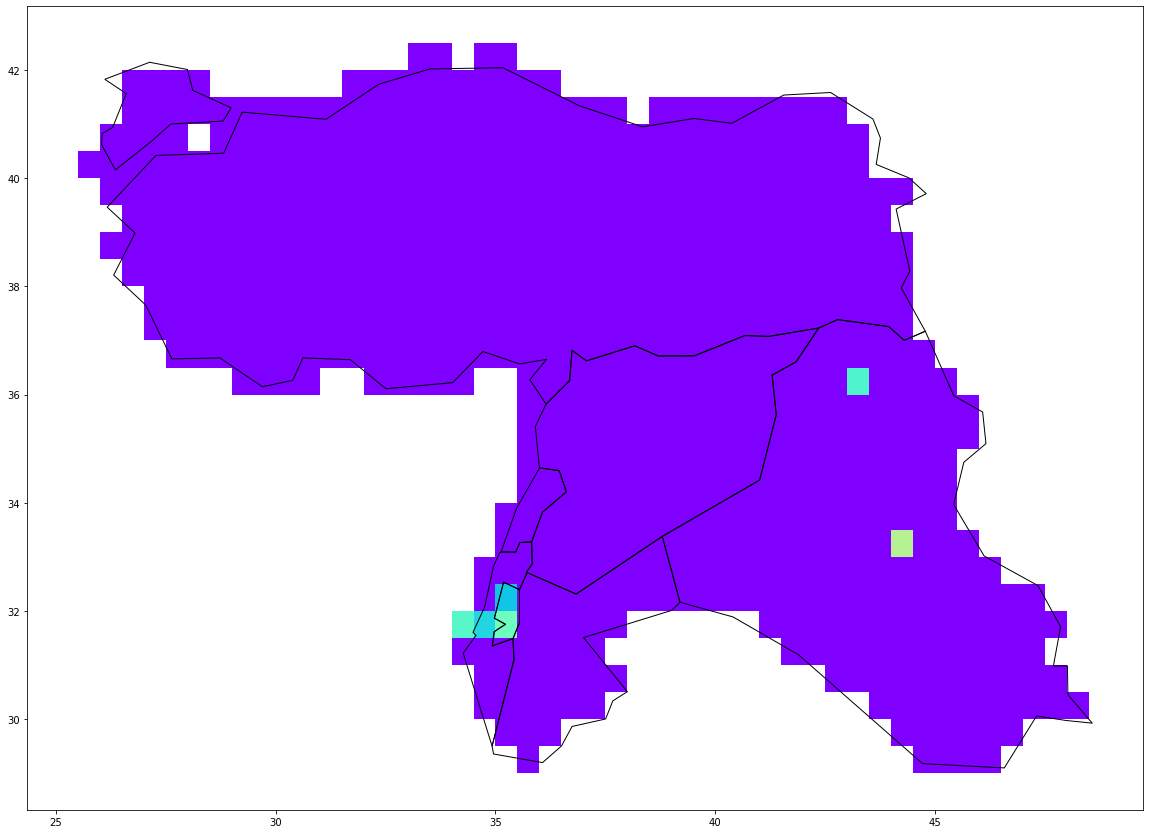

290: 2004-02


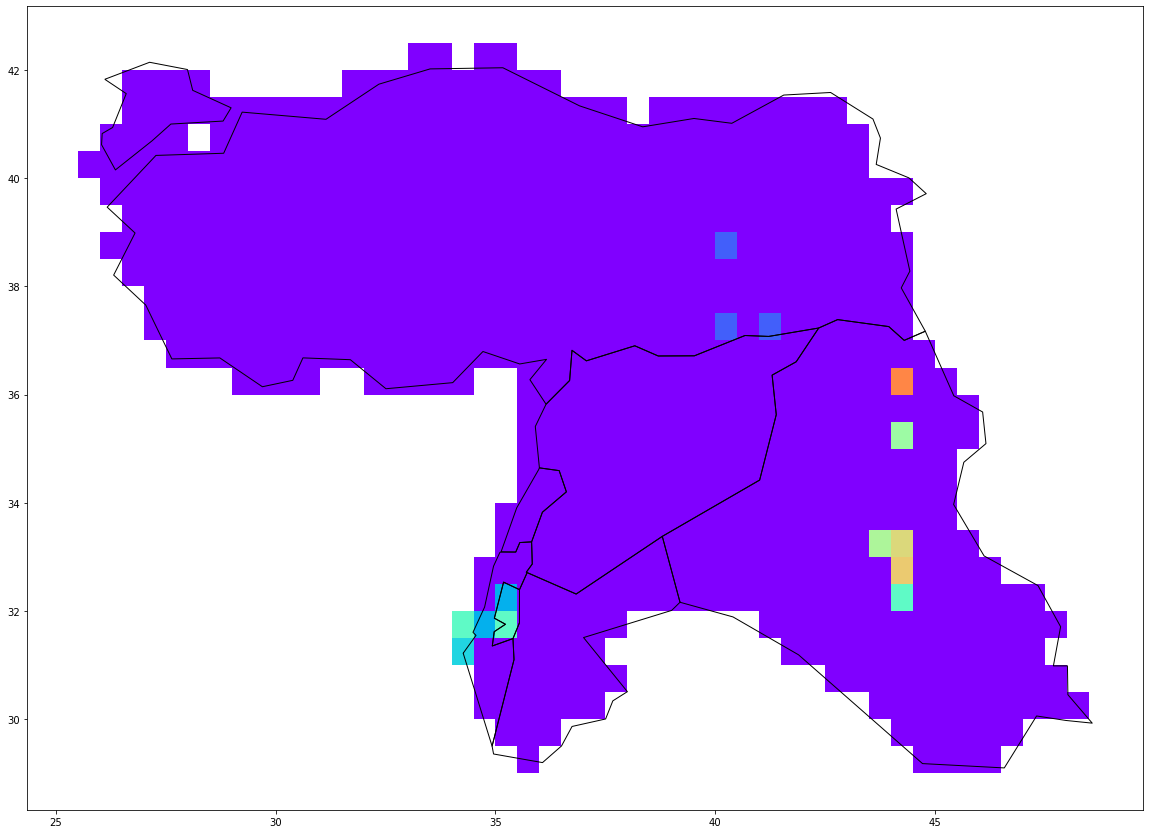

291: 2004-03


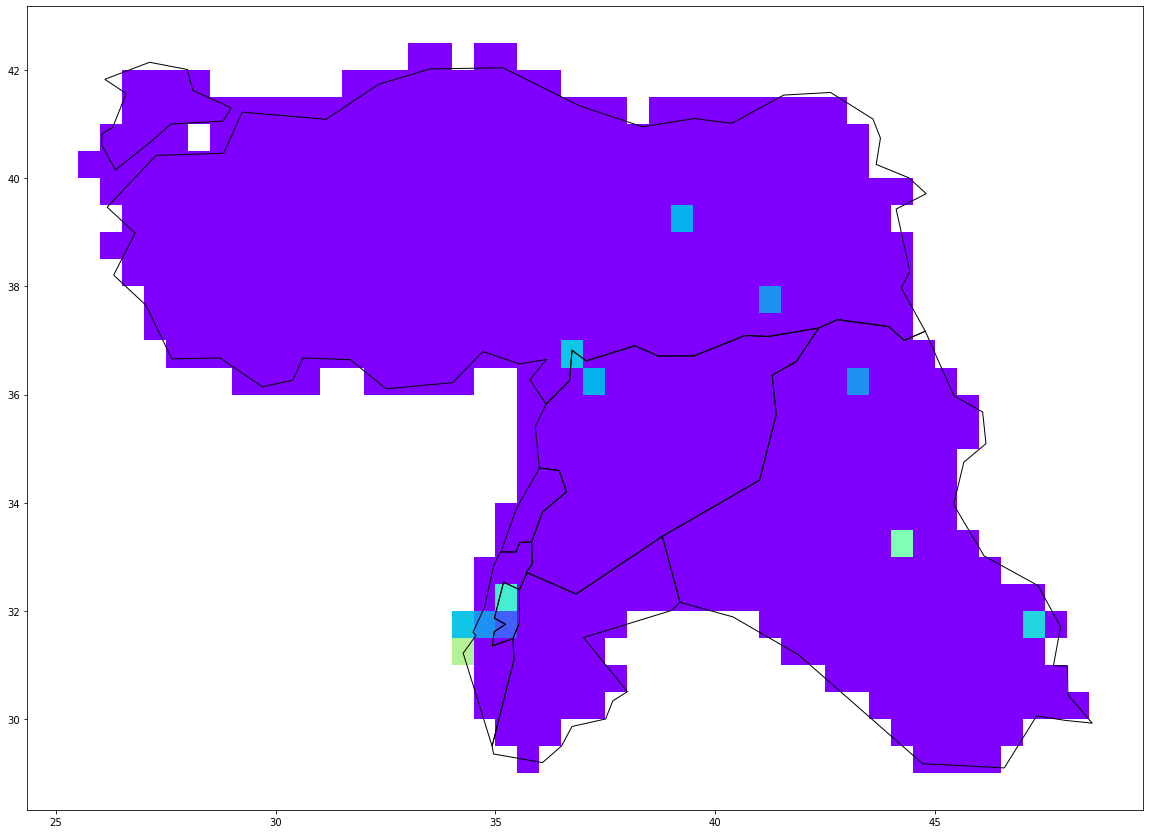

292: 2004-04


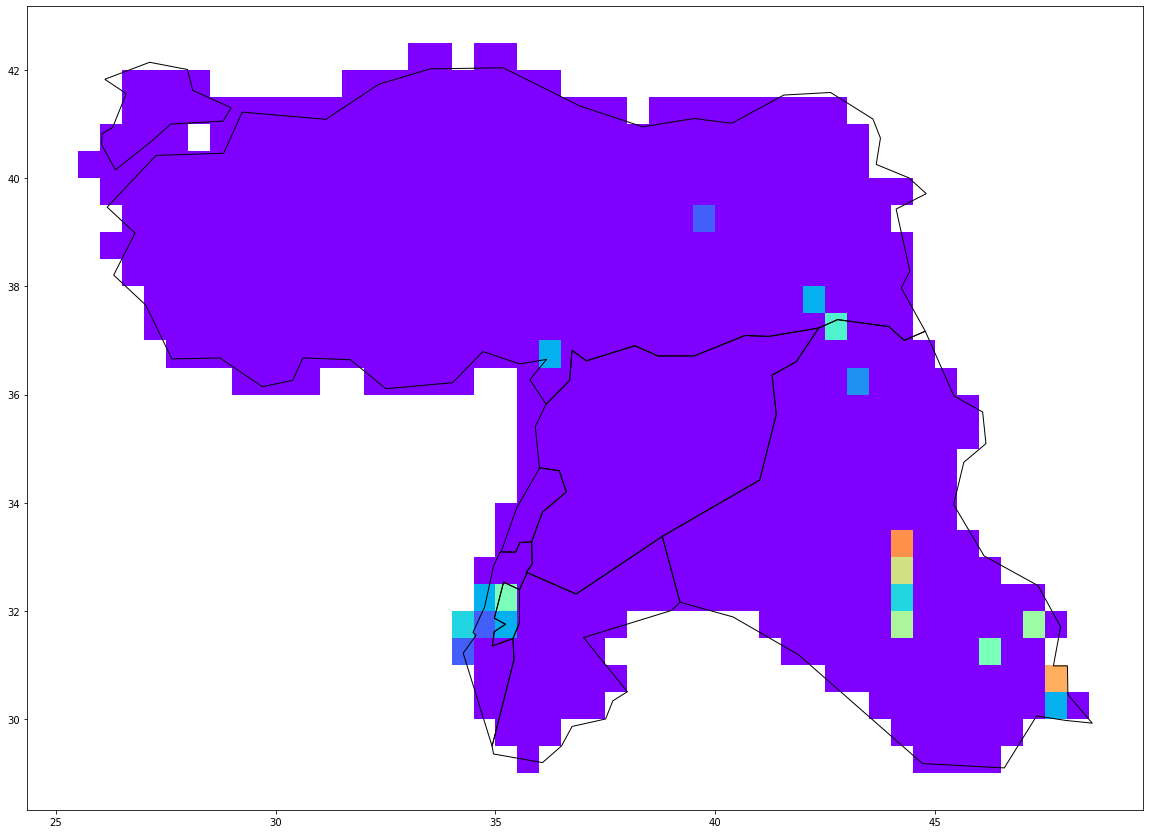

293: 2004-05


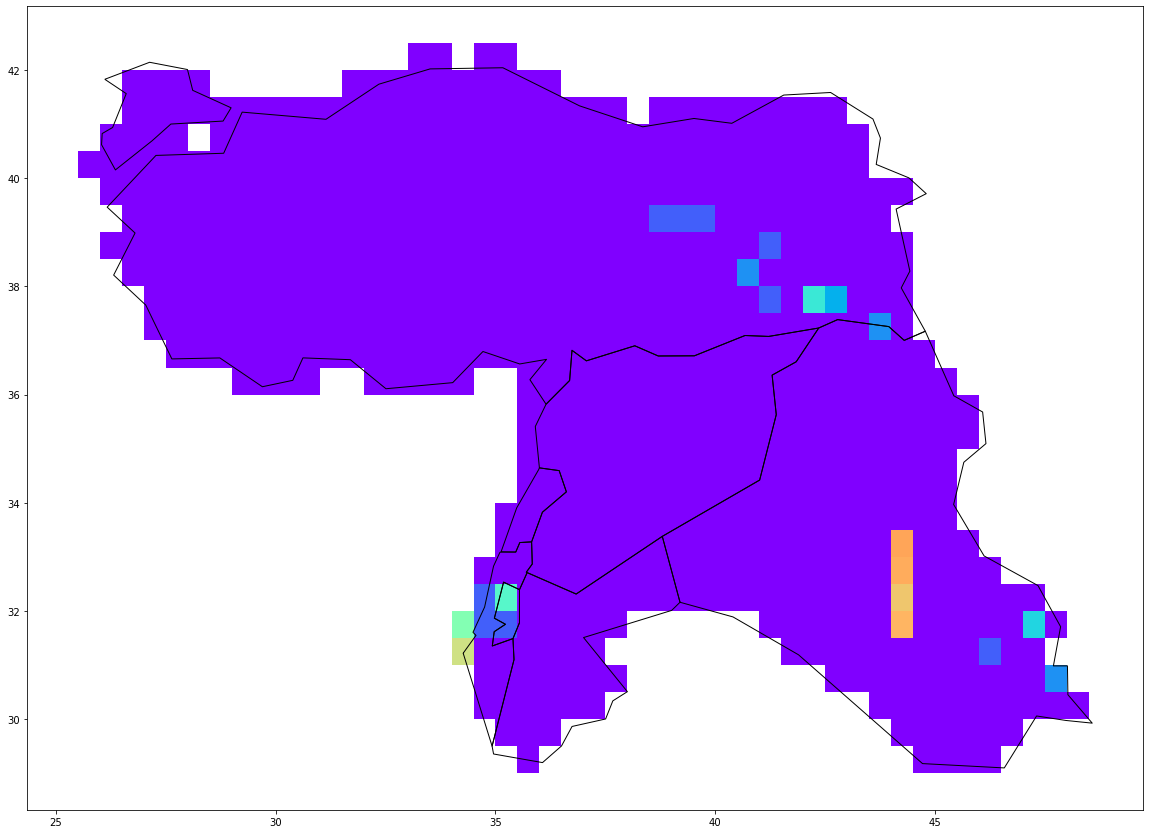

In [16]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()


for i in sorted(combined_df['month_id'].unique())[180:185]:

    print(f"{i}: {combined_df[combined_df['month_id'] == i]['year_months_start'].unique().item()}")

    fig, ax = plt.subplots(figsize = (20,20))

    ax.set_aspect('equal')

    #vmax = combined_df['log_best'].max()
    vmax = combined_df.loc[(combined_df['gwno'].isin(gwno_to_keep)) & (combined_df['month_id'].isin(np.arange(180, 185+1, 1))), 'log_best'].max()

    combined_df[(combined_df['gwno'].isin(gwno_to_keep)) & (combined_df['month_id'] == i)].plot(ax = ax, column = 'log_best', cmap = 'rainbow', vmin = 0, vmax = vmax)
    sub_world.plot(facecolor='none', edgecolor='black', ax=ax)
    plt.show()

In [17]:
bodies_gdf_month_id_gid = gpd.sjoin(bodies_gdf_month_id, gid_geom_df, how='left')
bodies_gdf_month_id_gid_fatal = bodies_gdf_month_id_gid.merge(combined_df[['gid', 'month_id', 'log_best', 'log_high', 'log_low']], how = 'left', on = ['gid', 'month_id'])

In [18]:
bodies_gdf_month_id_gid_fatal[['log_best', 'log_high', 'log_low']] = bodies_gdf_month_id_gid_fatal[['log_best', 'log_high', 'log_low']].fillna(value = 0)

In [19]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

with open(f'{data_dir}bodies_gdf_fatal.pkl', 'wb') as file:
    pickle.dump(bodies_gdf_month_id_gid_fatal, file)


# and as a normal pandas dataframe

bodies_df_month_id_gid_fatal = pd.DataFrame(bodies_gdf_month_id_gid_fatal.drop(columns= 'geometry').copy())

with open(f'{data_dir}bodies_df_fatal.pkl', 'wb') as file:
    pickle.dump(bodies_gdf_month_id_gid_fatal, file)

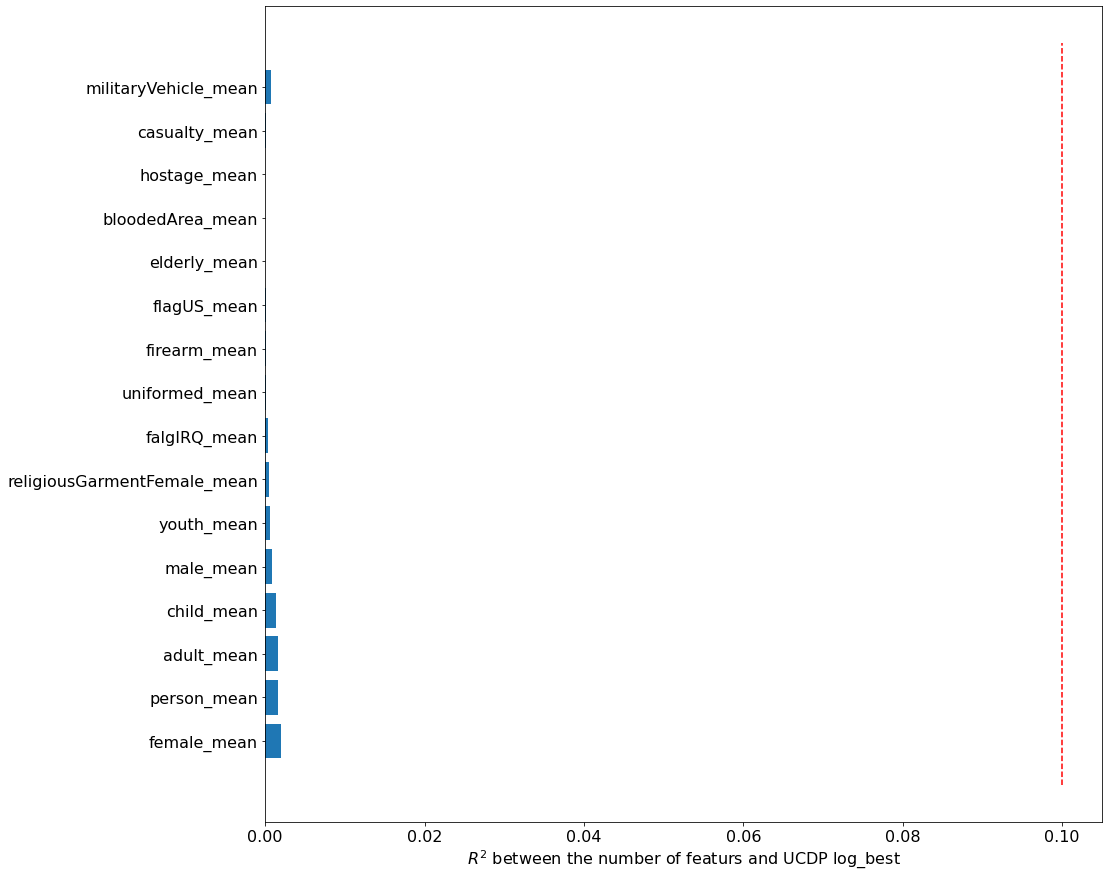

In [20]:
list_of_features_mean = [feature for feature in bodies_gdf_month_id_gid_fatal.columns if 'mean' in feature]

list_of_corr = []
list_of_features = []

for feature in list_of_features_mean:

    corr_score = bodies_gdf_month_id_gid_fatal[[feature, 'log_best']].corr(method='pearson').values[0,1]

    list_of_features.append(feature)
    list_of_corr.append(corr_score)

    #print(f"{feature}: {corr_score}")

dict_of_corr = {'features': list_of_features, 'corr' : list_of_corr}

df_corr = pd.DataFrame(dict_of_corr)
df_corr.sort_values('corr', ascending= False, inplace = True)
df_corr.reset_index(drop= True, inplace= True)


plt.figure(figsize= [15,15])
plt.barh(df_corr.index, df_corr['corr']**2)
plt.yticks(df_corr.index, df_corr['features'], fontsize = 16)
plt.xticks(fontsize = 16)
plt.xlabel("$R^2$ between the number of featurs and UCDP log_best", fontsize = 16)

plt.vlines(0.1, -1, df_corr.index.max()+1, colors= 'red', linestyles='dashed')

# plt.savefig(f'plots/annotated_correlation.pdf', bbox_inches="tight") 
plt.show()    

In [21]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression() 

for feature in list_of_features_mean[0:1]:

    y = bodies_gdf_month_id_gid_fatal[feature].values.reshape(-1, 1)
    x = bodies_gdf_month_id_gid_fatal['log_best'].values.reshape(-1, 1)

    lm.fit(x,y)

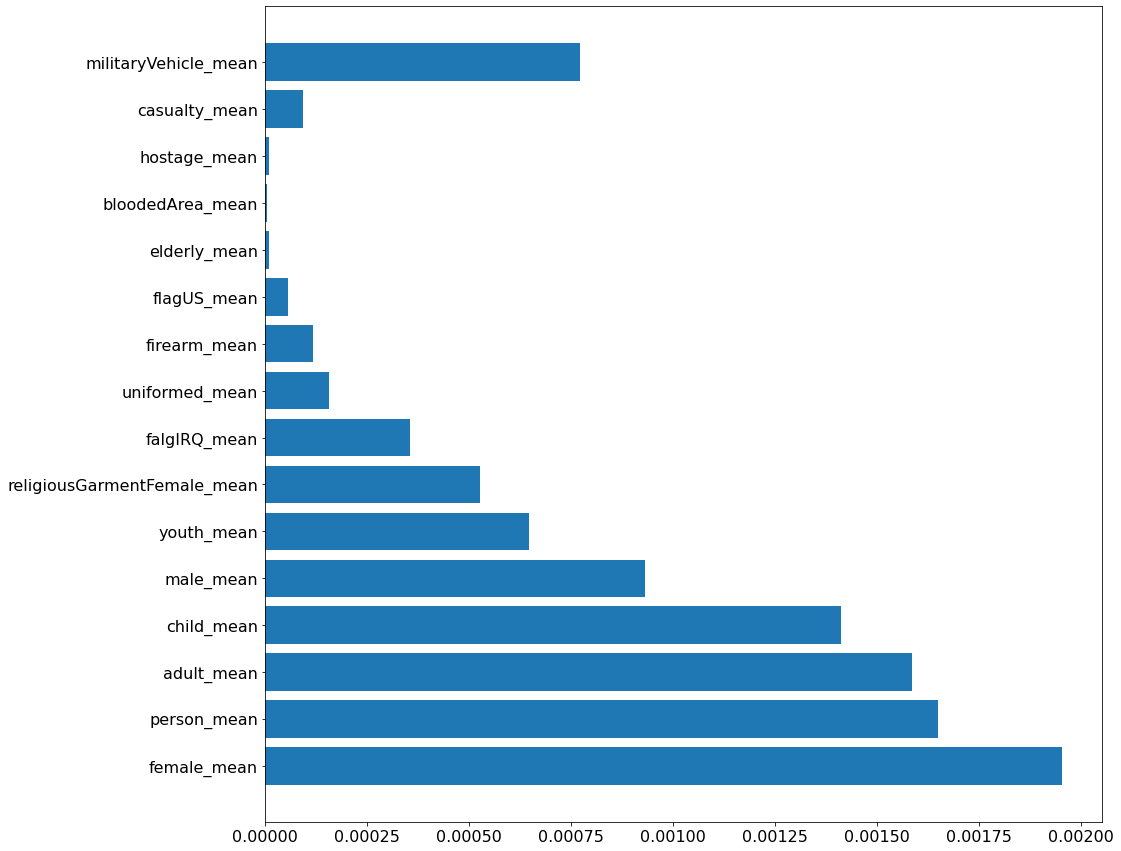

In [22]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression() 

list_of_features_mean = [feature for feature in bodies_gdf_month_id_gid_fatal.columns if 'mean' in feature]

list_of_coef = []
list_of_features = []

for feature in list_of_features_mean:

    y = bodies_gdf_month_id_gid_fatal[feature].values.reshape(-1, 1)
    x = bodies_gdf_month_id_gid_fatal['log_best'].values.reshape(-1, 1)

    lm.fit(x,y)

    list_of_features.append(feature)
    list_of_coef.append(lm.coef_.item())

    #print(f"{feature}: {corr_score}")

dict_of_coef = {'features': list_of_features, 'corr' : list_of_coef}

df_coef = pd.DataFrame(dict_of_coef)
df_coef.sort_values('corr', ascending= False, inplace = True)
df_coef.reset_index(drop= True, inplace= True)


plt.figure(figsize= [15,15])
plt.barh(df_coef.index, df_corr['corr']**2)
plt.yticks(df_coef.index, df_corr['features'], fontsize = 16)
plt.xticks(fontsize = 16)
# plt.xlabel("$R^2$ between the number of featurs and UCDP log_best", fontsize = 16)

#plt.vlines(0.1, -1, df_corr.index.max()+1, colors= 'red', linestyles='dashed')

# plt.savefig(f'plots/annotated_correlation.pdf', bbox_inches="tight") 
plt.show()  

# OLD

In [21]:
# import contextily as ctx

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()

cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities = cities.to_crs(bodies_gdf.crs)

# cities_mask = (cities['geometry'].x >25) & (cities['geometry'].x <45) & (cities['geometry'].y >28) & (cities['geometry'].y < 43)
cities_mask = ['Baghdad', 'Damascus', 'Amman', 'Ankara', 'Jerusalem', 'Beirut']

sub_cities = cities[cities['name'].isin(cities_mask)].copy()

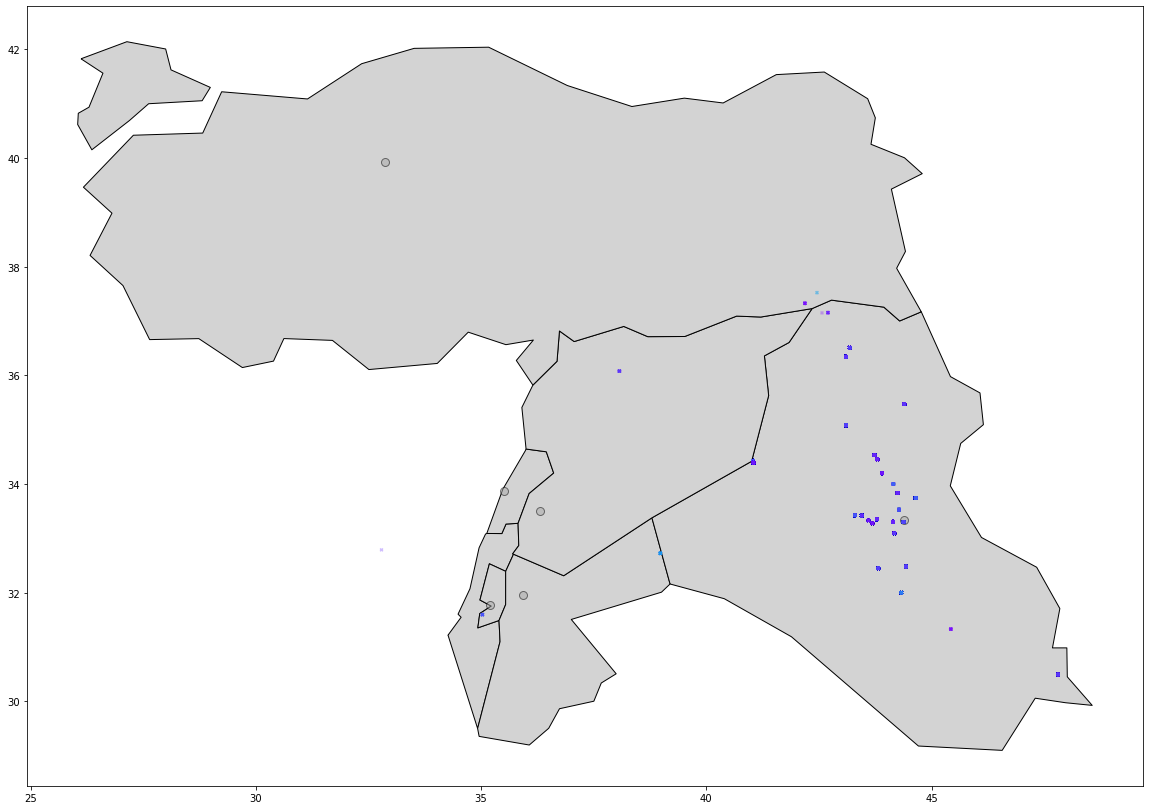

In [22]:
fig, ax = plt.subplots(figsize = (20,20))


# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.

ax.set_aspect('equal')

sub_world.plot(ax=ax, color='lightgray', edgecolor='black')
sub_cities.plot(ax=ax, marker='o', color='darkgray', edgecolor='black', markersize=64, alpha = 0.5)

bodies_gdf.plot(ax=ax, column = 'person_mean', marker='x', cmap = 'rainbow', markersize = 8, alpha = 0.3 )

path = '/home/simon/Documents/Bodies/figures/maps/'

#plt.savefig(path + '1606eks.pdf', bbox_inches = "tight")

#ax.figure.savefig(path + '1606eks.pdf', bbox_inches = "tight")


# fig = plt.gcf()
# fig.savefig(path + '1606eks.pdf', bbox_inches = "tight")

plt.show()

**So now use date to crate month ID.**

In [136]:
def get_month_id_bodies(bodies_gdf):

    # works!!
    years = np.arange(1989,2020,1) # just as big as combine for now
    #months = [np.arange(1,13,1)] * years.shape[0]
    months = [[str(i).zfill(2) for i in np.arange(1,13,1)]] * years.shape[0]

    month_id_df = pd.DataFrame({'year' : years, 'month' : months}).explode('month')
    month_id_df['month_id'] = np.arange(109, month_id_df.shape[0] + 109, 1)

    month_id_df['year_month'] = month_id_df['year'].astype(str) + '-' + month_id_df['month']
    bodies_gdf['year_month']= bodies_gdf['date'].astype(str).str.slice(start = 0, stop = 7)
    bodies_gdf_month_id = bodies_gdf.merge(month_id_df[['month_id','year_month']], how='left', on= 'year_month')

    return(bodies_gdf_month_id)


In [137]:
bodies_gdf_month_id = get_month_id_bodies(bodies_gdf)

In [154]:
for y in sorted(combined_df['year'].unique()):
    array = combined_df[combined_df['year'] == y]['month_id'].unique()
    print(f'{y}: {array}, lenght = {array.shape[0]}')

for y in sorted(bodies_gdf_month_id['year'].unique()[:-1]): # -1 because you do not want the nan
    array = bodies_gdf_month_id[bodies_gdf_month_id['year'].astype(float) == float(y)]['month_id'].unique()
    print(f'{y}: {array}, lenght = {array.shape[0]}')

1989: [109 110 111 112 113 114 115 116 117 118 119 120], lenght = 12
1990: [121 122 123 124 125 126 127 128 129 130 131 132], lenght = 12
1991: [133 134 135 136 137 138 139 140 141 142 143 144], lenght = 12
1992: [145 146 147 148 149 150 151 152 153 154 155 156], lenght = 12
1993: [157 158 159 160 161 162 163 164 165 166 167 168], lenght = 12
1994: [169 170 171 172 173 174 175 176 177 178 179 180], lenght = 12
1995: [181 182 183 184 185 186 187 188 189 190 191 192], lenght = 12
1996: [193 194 195 196 197 198 199 200 201 202 203 204], lenght = 12
1997: [205 206 207 208 209 210 211 212 213 214 215 216], lenght = 12
1998: [217 218 219 220 221 222 223 224 225 226 227 228], lenght = 12
1999: [229 230 231 232 233 234 235 236 237 238 239 240], lenght = 12
2000: [241 242 243 244 245 246 247 248 249 250 251 252], lenght = 12
2001: [253 254 255 256 257 258 259 260 261 262 263 264], lenght = 12
2002: [265 266 267 268 269 270 271 272 273 274 275 276], lenght = 12
2003: [277 278 279 280 281 282 283

In [141]:
sorted(bodies_gdf_month_id['year'].unique())

TypeError: '<' not supported between instances of 'float' and 'str'

In [153]:
sorted(bodies_gdf_month_id['year'].unique()[:-1])

['2003', '2004', '2005', '2006', '2007', '2008', '2009']

In [90]:
bodies_df['year_month']= bodies_df['date'].astype(str).str.slice(start = 0, stop = 7)

0         2008-12
1         2009-09
2         2007-10
3         2005-11
4         2005-11
           ...   
152436    2004-01
152437    2004-01
152438    2004-01
152439    2004-01
152440    2004-01
Name: date, Length: 152441, dtype: object

In [ ]:
def add_month_id(ucdp): # you could also do a week_id....

    ucdp_tmp1 = ucdp.copy()

    ucdp_tmp1['year_months_start'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD
    ucdp_tmp1['year_months_end'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD


    mask1 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_start'].str.slice(start = 0, stop = 4).astype(int))
    mask2 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_end'].str.slice(start = 0, stop = 4).astype(int))

    # correction. Note that end and start year for the four entries that is corrected is the same.
    ucdp_tmp1.loc[mask1 | mask2, 'year'] = ucdp_tmp1.loc[mask1 | mask2,'year_months_start'].str.slice(start = 0, stop = 4).astype(int)

    ds_uniques = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7).unique()
    de_uniques = ucdp_tmp1['date_end'].str.slice(start = 0, stop = 7).unique() # do you need both?

    months_unique = np.union1d(ds_uniques, de_uniques)
    months_unique.sort()

    month_id = np.arange(109, months_unique.shape[0] + 109, 1) # this makes sure the month_id matches that of ViWES replication data. Just in case.

    month_df = pd.DataFrame({'month_id' : month_id, 'year_months_start' : months_unique, 'year_months_end' : months_unique})

    # I checked. There is no instance where the month id will differ if we take start or end.
    ucdp_tmp2 = ucdp_tmp1.merge(month_df[['month_id', 'year_months_start']], how = 'outer', on= 'year_months_start')

    return(ucdp_tmp2)

Og når du har month_id sjoin'er du med et dataset der bare har gids og geomatry

så kan du merge med combined bagefter (eller hvad din plan nu er...)

du vil have en monthly fatlity count (log best, log_high, log_low) på hvert billede - men reel set vil du hellere have exposure...

Exposure er lidt mere overkommenligt med et så relativt lille område

In [24]:
def get_cshapes():
    location = '/home/simon/Documents/Bodies/data/PRIO' 
    path_cshapes = location + "/CShapes-2.0.csv"
    
    if os.path.isfile(path_cshapes) == True:
        print('file already downloaded')
        cshapes = pd.read_csv(path_cshapes)


    else: 
        print('Beginning file download CShapes...')

        url_cshapes = 'https://icr.ethz.ch/data/cshapes/CShapes-2.0.csv'
    
        urllib.request.urlretrieve(url_cshapes, path_cshapes)
        cshapes = pd.read_csv(path_cshapes)

    return cshapes




In [25]:
cshapes = get_cshapes()

Beginning file download CShapes...


In [33]:
cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()

In [ ]:
cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()

289: 2004-01


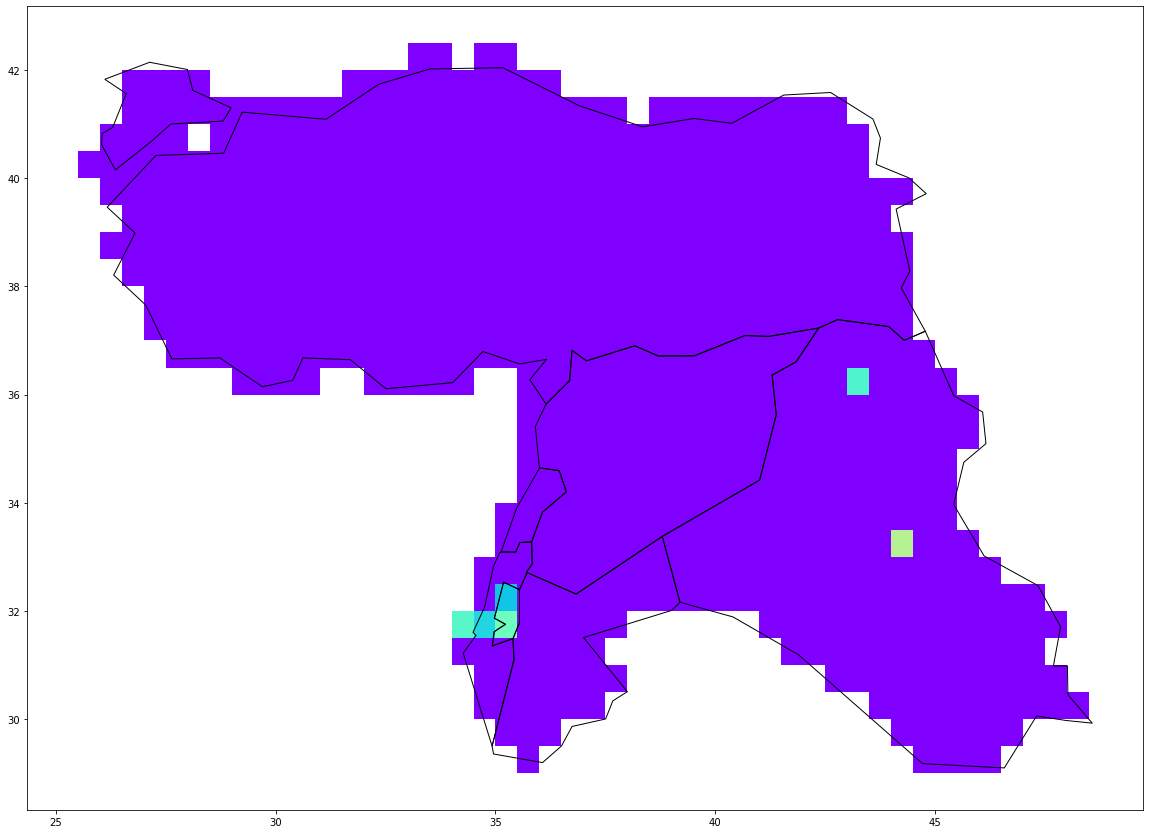

290: 2004-02


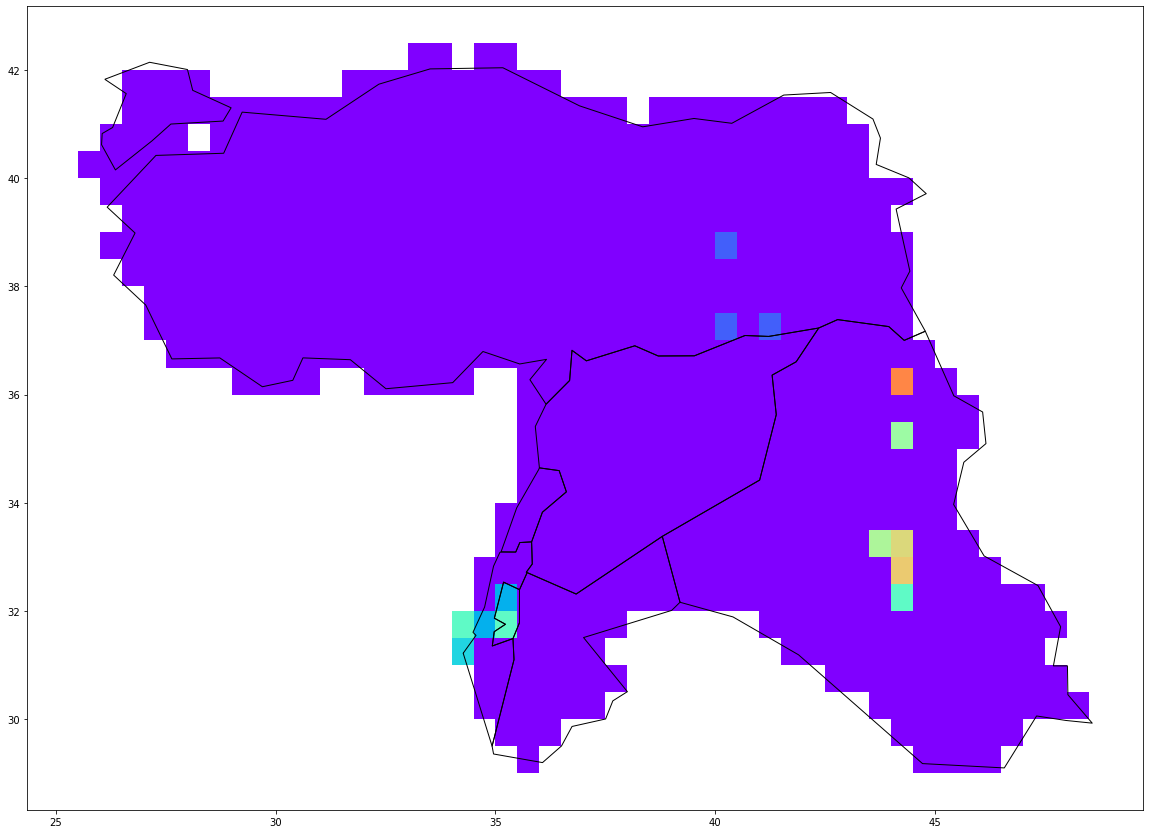

291: 2004-03


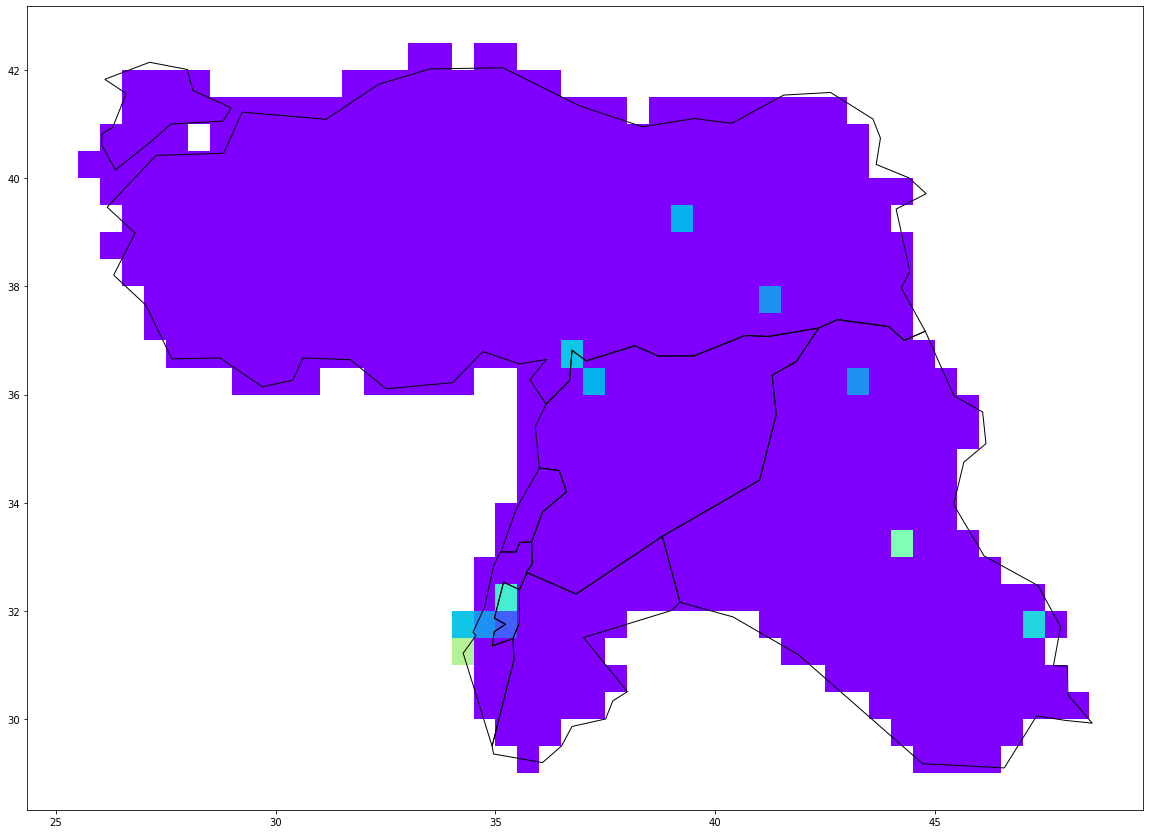

292: 2004-04


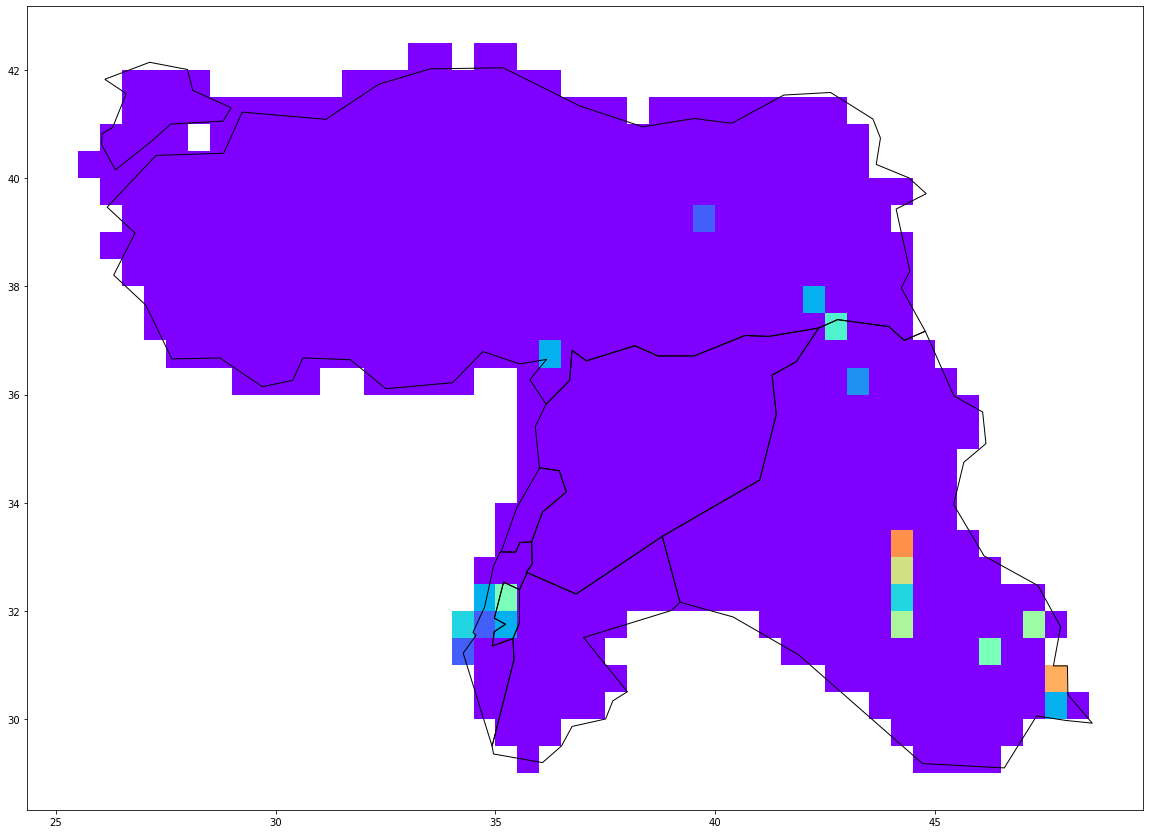

293: 2004-05


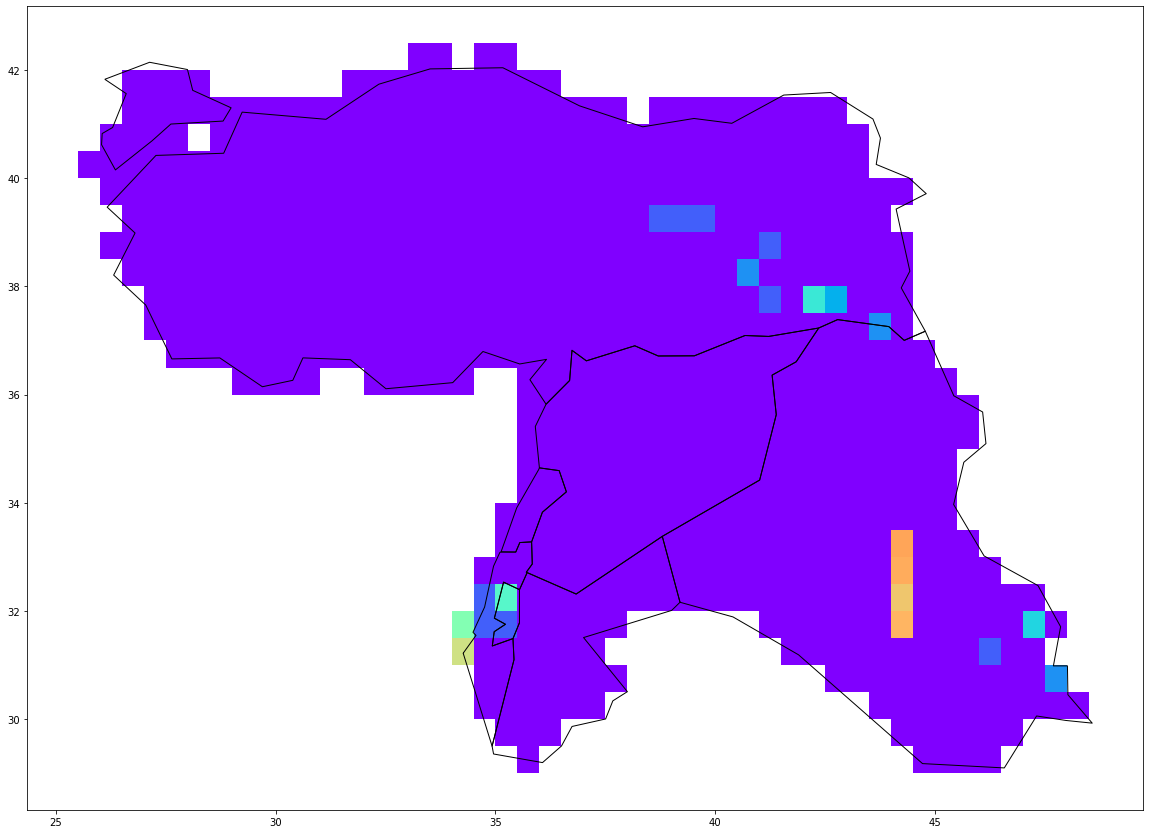

In [49]:
for i in sorted(combined_df['month_id'].unique())[180:185]:

    print(f"{i}: {combined_df[combined_df['month_id'] == i]['year_months_start'].unique().item()}")

    fig, ax = plt.subplots(figsize = (20,20))

    ax.set_aspect('equal')

    #vmax = combined_df['log_best'].max()
    vmax = combined_df.loc[(combined_df['gwno'].isin(gwno_to_keep)) & (combined_df['month_id'].isin(np.arange(180, 185+1, 1))), 'log_best'].max()

    combined_df[(combined_df['gwno'].isin(gwno_to_keep)) & (combined_df['month_id'] == i)].plot(ax = ax, column = 'log_best', cmap = 'rainbow', vmin = 0, vmax = vmax)
    sub_world.plot(facecolor='none', edgecolor='black', ax=ax)
    plt.show()


# OLD

<AxesSubplot:>

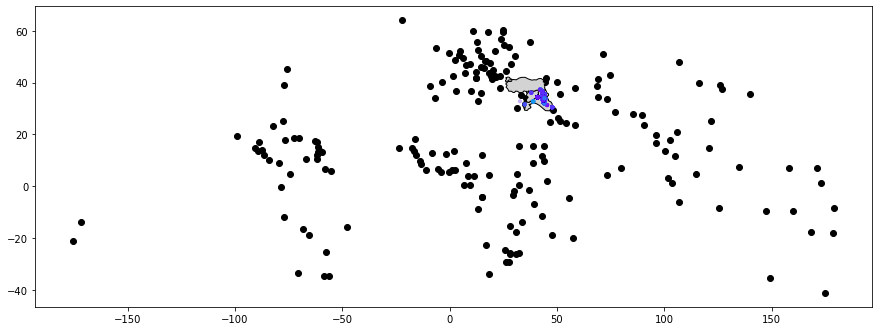

In [99]:
fig, ax = plt.subplots(figsize = (15,15))

#ax.set_aspect('equal') # don't know if this is relevant....

cities.plot(color = 'black', marker='o', ax=ax) 
sub_world.plot(color='lightgray', edgecolor='black', ax=ax)
bodies_gdf.plot(column = 'person_mean', marker='o', ax=ax, cmap = 'rainbow', markersize = 10, alpha = 0.3 )

<AxesSubplot:>

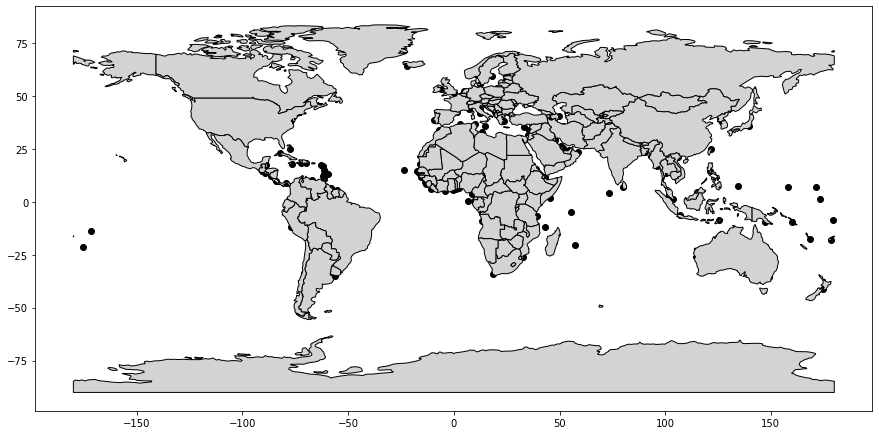

In [100]:
fig, ax = plt.subplots(figsize = (15,15))

#ax.set_aspect('equal') # don't know if this is relevant....

cities.plot(color = 'black', marker='o', ax=ax) 
world.plot(color='lightgray', edgecolor='black', ax=ax)

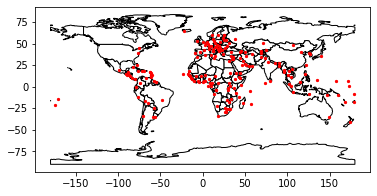

In [101]:
fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

cities.plot(ax=ax, marker='o', color='red', markersize=5)

plt.show()

In [90]:
cities.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [91]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [92]:
bodies_gdf.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

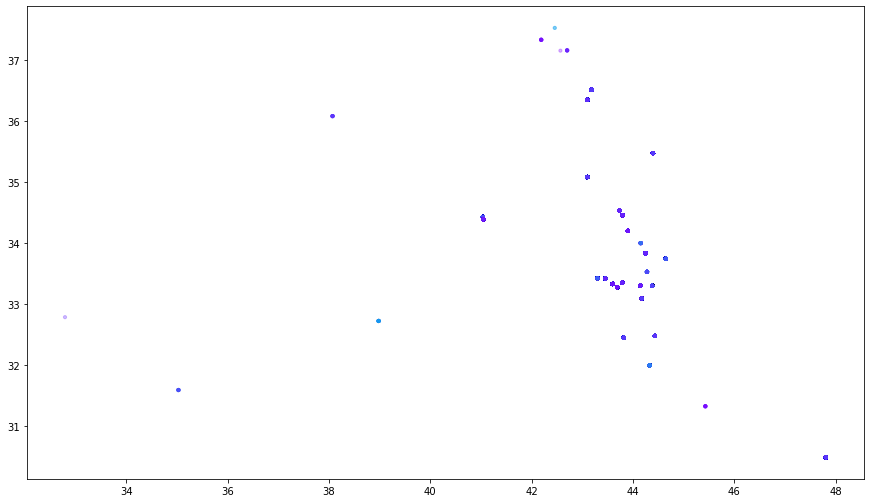

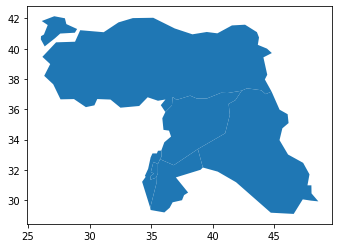

In [68]:
fig, ax = plt.subplots(figsize = (15,15))
sub_world.plot()
bodies_gdf.plot(column = 'person_mean', ax=ax, cmap = 'rainbow', markersize = 10, alpha = 0.3 )

In [ ]:
plt.figure(figsize= [15,15])

x = bodies_df_ll['longitude_full'] + np.random.randn(bodies_df_ll['longitude_full'].shape[0])/12 
y = bodies_df_ll['latitude_full'] + np.random.randn(bodies_df_ll['longitude_full'].shape[0])/12

plt.scatter(x,y, alpha = 0.8, s= 1)
plt.show()

Cut out relevant countirs first

from get_coordinates.ipynd

iraq, Jordan, Palestinian Territory, Syria, Turkey

'Israel', 'Iraq' 'Jordan', 'Syria', 'Turkey


<AxesSubplot:>

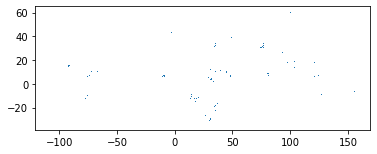

In [58]:
pu_df[pu_df['month_id'] == 121].plot()

In [56]:
# maybe just do a square cutout.
county_mask = ['Israel', 'Iraq', 'Jordan', 'Syria', 'Turkey']
sub_pu_df = pu_df[pu_df['country'].isin(county_mask)].copy()

<AxesSubplot:>

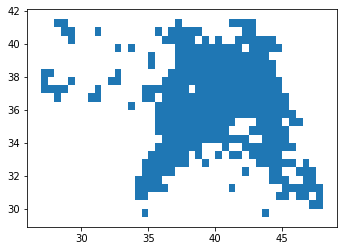

In [57]:
sub_pu_df.plot()

In [31]:
combined_df = gpd.sjoin(bodies_gdf, pu_df, how="right", op='within')

/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_113727/3710844654.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  combined_df = gpd.sjoin(bodies_gdf, pu_df, how="right", op='within')


: 

: 

In [1]:
pu_df.csr

NameError: name 'pu_df' is not defined

In [15]:
bodies_gdf = gpd.GeoDataFrame(bodies_df)
bodies_gdf.set_geometry()

1

In [ ]:
geometry = [Point(xy) for xy in zip(bodies_df['longitude_full'], bodies_df['latitude_full'])]

In [22]:
Point(bodies_df[['latitude_full', 'longitude_full']])

KeyError: 0

In [221]:
def elong_df(df, df_w_time, temporal_unit):

    """While a bit hacky, this works. It extents the prio grid to match any temporal unit"""

    t = sorted(df_w_time[temporal_unit].unique())
    df[temporal_unit] = t[0]
    concat_df = df.copy()

    for i,j in enumerate(t[1:]):

        df_temp = df.copy()
        df_temp[temporal_unit] = j

        concat_df = pd.concat([concat_df, df_temp])
    
    concat_df.reset_index(inplace = True)
    return concat_df 

In [222]:
# maybe not the way...
# prio_grid_t = elong_df(prio_grid, ucdp_gid, 'month_id')

KeyboardInterrupt: 

In [ ]:
# maybe not the way...

In [ ]:

def elong_df(df, df_w_years):

    """While a bit hacky, this works. It extents the prio grid to match any temporal unit"""

    years = sorted(df_w_years['year'].unique())
    df['year'] = years[0]
    concat_df = df.copy()

    for i,j in enumerate(years[1:]):

        df_temp = df.copy()
        df_temp['year'] = j

        concat_df = pd.concat([concat_df,df_temp])
    
    concat_df.reset_index(inplace = True)
    return concat_df 


In [ ]:

def make_df(prio_grid, ucdp):

    print('Creating DF...')

    ucdp_gid = trim_ucdp(ucdp=ucdp)
    prio_grid_yearly = elong_df(prio_grid, ucdp_gid)

    grid_ucdp =  pd.merge(prio_grid_yearly, ucdp_gid, how = 'left', on = ['gid', 'year'])
    grid_ucdp.fillna({'best' : 0, 'low' : 0, 'high' : 0, 'log_best' : 0, 'log_low' : 0, 'log_high' : 0}, inplace = True)

    grid_ucdp = grid_ucdp[['gid', 'xcoord', 'ycoord', 'year', 'best', 'low', 'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col.

    grid_ucdpS = grid_ucdp.sort_values(['year', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = grid_ucdp['xcoord'].unique().shape[0]
    y_dim = grid_ucdp['ycoord'].unique().shape[0]
    z_dim = grid_ucdp['year'].unique().shape[0]

    ucpd_vol = np.array(grid_ucdpS).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol